In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os 
import sys
import time
import tensorflow as tf
from tensorflow import keras
from pprint import pprint

print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

sys.version_info(major=3, minor=7, micro=5, releaselevel='final', serial=0)
matplotlib 3.1.2
numpy 1.17.4
pandas 0.25.3
sklearn 0.22
tensorflow 2.0.0
tensorflow_core.keras 2.2.4-tf


## 1. 数据的获取与处理

In [2]:
fashion_mnist = keras.datasets.fashion_mnist
(x_train_all, y_train_all), (x_test, y_test) = fashion_mnist.load_data()
x_valid, x_train = x_train_all[:5000], x_train_all[5000:]
y_valid, y_train = y_train_all[:5000], y_train_all[5000:]

In [3]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(
    x_train.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28, 1)
x_valid_scaled = scaler.transform(
    x_valid.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28, 1)
x_test_scaled = scaler.transform(
    x_test.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28, 1)

## 2. 建模与训练

### 2.1【重点】 定义深度可分离卷积网络

原理：以损失精度为代价带来参数和运算量的减少，从而可以在低运算资源的移动设备上进行运算

In [4]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(filters=32, 
                              kernel_size=3, 
                              padding="same", 
                              activation="selu",
                              input_shape=(28, 28, 1)))
model.add(keras.layers.SeparableConv2D(filters=32,
                                       kernel_size=3,
                                       padding="same",
                                       activation="selu"))
model.add(keras.layers.MaxPool2D(pool_size=2))
model.add(keras.layers.SeparableConv2D(filters=64,
                                       kernel_size=3,
                                       padding="same",
                                       activation="selu"))
model.add(keras.layers.SeparableConv2D(filters=64, 
                                       kernel_size=3,
                                       padding="same",
                                       activation="selu"))
model.add(keras.layers.MaxPool2D(pool_size=2))
model.add(keras.layers.SeparableConv2D(filters=128, 
                                       kernel_size=3,
                                       padding="same",
                                       activation="selu"))
model.add(keras.layers.SeparableConv2D(filters=128,
                                       kernel_size=3,
                                       padding="same",
                                       activation="selu"))
model.add(keras.layers.MaxPool2D(pool_size=2))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128, activation="selu"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [5]:
model.compile(loss="sparse_categorical_crossentropy",
              profilesor=10000,
              optimizer="sgd",
              metrics=["accuracy"])

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
separable_conv2d (SeparableC (None, 28, 28, 32)        1344      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 14, 14, 64)        2400      
_________________________________________________________________
separable_conv2d_2 (Separabl (None, 14, 14, 64)        4736      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
separable_conv2d_3 (Separabl (None, 7, 7, 128)         8

In [7]:
logdir = "./separable_cnn_selu_callbacks"
if not os.path.exists(logdir):
    os.mkdir(logdir)
    
output_model_file = os.path.join(logdir, "fashion_mnist_model.h5")

callbacks = [keras.callbacks.TensorBoard(logdir, profile_batch=100000000),
             keras.callbacks.ModelCheckpoint(output_model_file, 
                                        save_best_only=True),
             keras.callbacks.EarlyStopping(patience=5,
                                           min_delta=1e-2)]

In [8]:
history = model.fit(x_train_scaled, 
                    y_train,
                    epochs=10, 
                    validation_data=(x_valid_scaled, y_valid),
                    callbacks=callbacks)

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 101s 2ms/sample - loss: 2.2723 - accuracy: 0.1494 - val_loss: 1.6403 - val_accuracy: 0.4600
Epoch 2/10
55000/55000 [==============================] - 110s 2ms/sample - loss: 0.8767 - accuracy: 0.6803 - val_loss: 0.7056 - val_accuracy: 0.7376
Epoch 3/10
55000/55000 [==============================] - 100s 2ms/sample - loss: 0.6871 - accuracy: 0.7431 - val_loss: 0.6388 - val_accuracy: 0.7676
Epoch 4/10
55000/55000 [==============================] - 100s 2ms/sample - loss: 0.5996 - accuracy: 0.7730 - val_loss: 0.5231 - val_accuracy: 0.8062
Epoch 5/10
55000/55000 [==============================] - 99s 2ms/sample - loss: 0.5366 - accuracy: 0.7972 - val_loss: 0.5109 - val_accuracy: 0.8052
Epoch 6/10
55000/55000 [==============================] - 99s 2ms/sample - loss: 0.4929 - accuracy: 0.8137 - val_loss: 0.4500 - val_accuracy: 0.8378
Epoch 7/10
55000/55000 [=============================

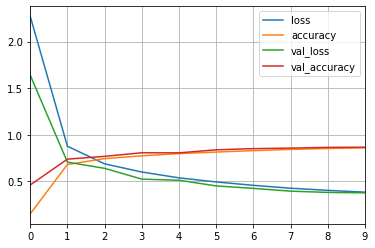

In [9]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(6, 4), grid=True)
    plt.show()

plot_learning_curves(history)

In [10]:
model.evaluate(x_test_scaled, y_test)

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.41475426383018493, 0.8506]